### Imports

In [10]:
import pyspark
import matplotlib.pyplot as plt
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from functools import reduce

### Preprocessing

We first initialize the spark session and then import all the data from user reviews. Here is a link to our dataset: https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews 

In [11]:
spark = SparkSession.builder.appName("balancing").getOrCreate()

In [12]:
csv_files = glob.glob('./dataset/reviews_*.csv')
dfs = []
for file in csv_files:
    df = spark.read.csv(file, header=True, inferSchema=True)
    dfs.append(df)
data = reduce(lambda df1, df2: df1.union(df2), dfs)

Now we ask: are the reviews of different products balanced? ie, do we have enough reviews of every item ? To answer this, let's take a look at the distribution of our data

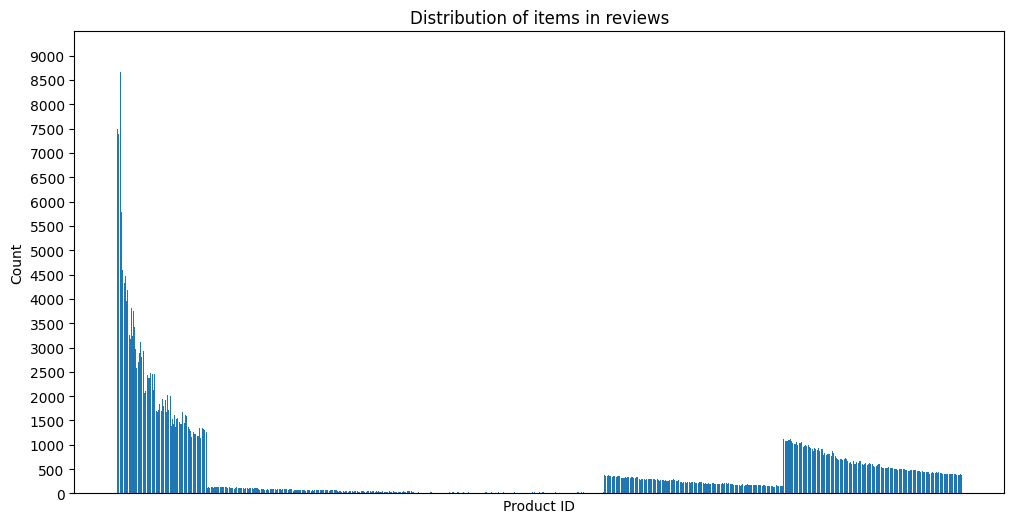

In [13]:
items = data.groupBy('product_id').count()
item_stats = items.filter(col('count').isNotNull() & col('product_id').startswith('P'))
pandas_items = item_stats.toPandas()
plt.figure(figsize=(12, 6))
plt.bar(pandas_items['product_id'], pandas_items['count'])
plt.xticks([])
plt.ylim(0, 9500)
plt.yticks(range(0, 9500, 500))
plt.xlabel('Product ID')
plt.ylabel('Count')
plt.title('Distribution of items in reviews')
plt.show()

As we can see, the set is greatly imbalaced, the  majority of products have between 500 and a little over 1000, with a considerable number having less than 500 and a few over 2000. To account for popularity, or lack thereof, of all items, we will maintain all those datapoints in our datamodel.

Now we ask ourselves this: do we a balanced amount of reviews across users? To answer this, given a number of reviews Y , we will plot Y against the number of users whose total reviews amount to Y.

,count
508848,1
393689,1
393692,1
216144,1
216142,1
...,...
258335,151
195730,155
65471,155
6771,210


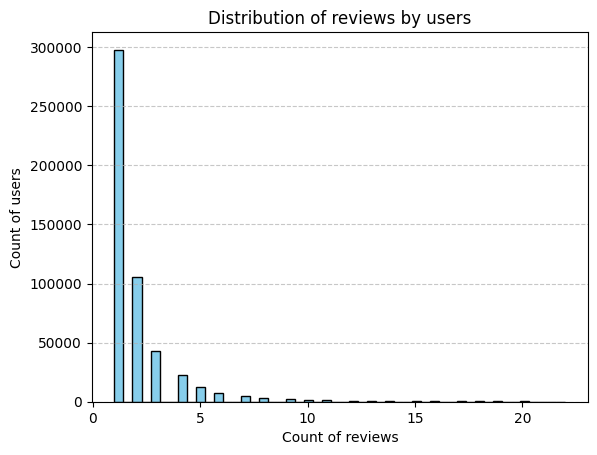

In [14]:
user_reviews = data.groupBy('author_id').count()
user_reviews =user_reviews.filter(col('author_id').isNotNull()).drop('author_id')
pandas_reviews = user_reviews.toPandas()
pandas_reviews = pandas_reviews.sort_values(by=['count'])
display(pandas_reviews)
review_counts = pandas_reviews['count'].value_counts().sort_index()
plt.hist(pandas_reviews['count'], bins=50, range=(1, 22), color='skyblue', edgecolor='black')
plt.xlabel('Count of reviews')
plt.ylabel('Count of users')
plt.title('Distribution of reviews by users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can now start taking a look into our data itself.

We want to disregard items that aren't related to skin type, eye colour or skin tone. Let's look at the item categories we have.

In [15]:
product_data_df = spark.read.csv('/dataset/product_info.csv', header=True, inferSchema=True)
product_data_df.select('primary_category').distinct().show()
product_data_df.select('secondary_category').distinct().show()

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/drive/MyDrive/dataset/items/product_info.csv.

We can now see that we essentially want to keep makeup, skincare and 

In [ ]:
filtered_product_data_df = product_data_df.filter(
    ~col('primary_category').isin(['Fragrance', 'Hair', 'All Hair Types']) &
    ~col('secondary_category').isin(['Fragrance','Hair Tools', 'Shampoo & Conditioner']))
filtered_product_data_df.select('product_id', 'primary_category', 'secondary_category', 'tertiary_category').show(10)
#filtering out reviews of unexisting products
valid_product_ids_df = filtered_product_data_df.select('product_id').distinct()
valid_reviews_df = data.join(valid_product_ids_df, "product_id", "semi")
valid_reviews_df.show(10)

+----------+----------------+--------------------+--------------------+
|product_id|primary_category|  secondary_category|   tertiary_category|
+----------+----------------+--------------------+--------------------+
|   P476416|     Bath & Body|   Body Moisturizers|Body Lotions & Bo...|
|   P476418|     Bath & Body|   Value & Gift Sets|                NULL|
|   P476417|     Bath & Body|   Value & Gift Sets|                NULL|
|   P503832|     Bath & Body|   Body Moisturizers|Body Lotions & Bo...|
|   P380571|     Bath & Body|           Body Care|Deodorant & Antip...|
|   P398965|          Makeup|                 Lip|Lip Balm & Treatment|
|   P439055|        Skincare|        Moisturizers|        Moisturizers|
|   P421277|        Skincare|          Treatments|         Face Serums|
|   P467602|        Skincare|            Eye Care|Eye Creams & Trea...|
|   P432045|        Skincare|Lip Balms & Treat...|                NULL|
+----------+----------------+--------------------+--------------

24/03/21 19:32:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+--------+--------------------+-----------+------+-------+--------------------+--------------+----------------+--------------------+--------------------+---------+---------------+--------------+---------------+---+-----------+------------+-----------------+--------------------+----------------+--------------------+--------------------+-----------+---------------+---------------+
|product_id|        product_name|brand_id|          brand_name|loves_count|rating|reviews|                size|variation_type| variation_value|      variation_desc|         ingredients|price_usd|value_price_usd|sale_price_usd|limited_edition|new|online_only|out_of_stock|sephora_exclusive|          highlights|primary_category|  secondary_category|   tertiary_category|child_count|child_max_price|child_min_price|
+----------+--------------------+--------+--------------------+-----------+------+-------+--------------------+--------------+----------------+--------------------+--------

24/03/21 19:32:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , author_id, rating, is_recommended, helpfulness, total_feedback_count, total_neg_feedback_count, total_pos_feedback_count, submission_time, review_text, review_title, skin_tone, eye_color, skin_type, hair_color, product_id, product_name, brand_name, price_usd
 Schema: _c0, author_id, rating, is_recommended, helpfulness, total_feedback_count, total_neg_feedback_count, total_pos_feedback_count, submission_time, review_text, review_title, skin_tone, eye_color, skin_type, hair_color, product_id, product_name, brand_name, price_usd
Expected: _c0 but found: 
CSV file: file:///Users/fatimaelfouladi/Documents/GitHub/SOEN471/dataset/reviews_0-250.csv
24/03/21 19:32:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , author_id, rating, is_recommended, helpfulness, total_feedback_count, total_neg_feedback_count, total_pos_feedback_count, submission_time, review_text, review_ti

+----------+------+-----------+------+--------------+-----------+--------------------+------------------------+------------------------+---------------+--------------------+--------------------+-----------+---------+-----------+----------+--------------------+----------+---------+--------------------+--------+----------+-----------+------+-------+--------------+--------------+---------------+--------------+--------------------+---------+---------------+--------------+---------------+---+-----------+------------+-----------------+--------------------+----------------+------------------+--------------------+-----------+---------------+---------------+
|product_id|   _c0|  author_id|rating|is_recommended|helpfulness|total_feedback_count|total_neg_feedback_count|total_pos_feedback_count|submission_time|         review_text|        review_title|  skin_tone|eye_color|  skin_type|hair_color|        product_name|brand_name|price_usd|        product_name|brand_id|brand_name|loves_count|rating|r

Now that we have the relevant review, we want to ensure that every review of a skincare product, has the relevant user info ie skin_type.

In [ ]:
valid_reviews_df = valid_reviews_df.filter(col('skin_type').isNull())
valid_reviews_df = valid_reviews_df.select(,
        col('product_id'),
        col('author_id'),
        col('is_recommended'),
        col('review_text'),
        col('review_title'),
        col('product_name'),
        col('skin_type'),
        col('brand_name'),
        col('skin_type')
        )
    print(valid_reviews_df.count())

+----------------+
|primary_category|
+----------------+
|Skincare        |
+----------------+



+----------------------+
|secondary_category    |
+----------------------+
|Moisturizers          |
|Masks                 |
|Wellness              |
|Cleansers             |
|Treatments            |
|High Tech Tools       |
|Mini Size             |
|Eye Care              |
|Shop by Concern       |
|Self Tanners          |
|Value & Gift Sets     |
|Sunscreen             |
|Lip Balms & Treatments|
+----------------------+



24/03/21 19:52:05 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 481765 ms exceeds timeout 120000 ms
24/03/21 19:52:05 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/21 19:52:07 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$